In [240]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Table of content
1. Define functions, load data
    - Import `interactive` maps module
    - Define functions for calculating `distance` on Earth
    - Load DataFrames for `apartaments` and `metro` 
2. Prepare data
    - Add `price` to `rental price` in order to get `real price`
    - Find `distance` to nearest metro station for all valid houses
    - Find `distance` to city center (`PKiN`) for all valid houses
    - Read `districts'` shape data
    - Assign `districts` to all houses 
3. Analyse dataset
    - Price `violinplots` for each district
    - Show median price for each district (**interactive map**) 
    - Correlate `data` (**with strong interpretations**)
    - **Big heatmap** with exageratted colors
    - Various interesting `correlated plots`
    - Distribution of apartment's floor level
4. Prediction
    - Import libraries
    - Prepare input (`x`) and target (`y`) variables 
    - Split to `training` and `test` set, then scale values
    - Learn using `support vector mashines (SVM)` with `rbf` kernel
    - Calculate error on `train set`
    - Calculate error on `test set`
    - Analyse of `error` in regression approach (**unique method**)
    - Test on some hand-typed data 

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [241]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [242]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [243]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [244]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Load DataFrames for `apartaments` and `metro`

In [517]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

In [518]:
apartaments.head()

,Cena,Powierzchnia,Liczba pokoi,Rynek,Rodzaj zabudowy,Piętro,Liczba pięter,Materiał budynku,Okna,Rok budowy,Stan wykończenia,Czynsz,Forma własności,φ,λ,Ogrzewanie,Czas dojazdu do centrum
0,850000.0,60.0,3,wtórny,kamienica,2,3.0,cegła,plastikowe,1950.0,do zamieszkania,541 zł,spółdzielcze wł. z KW,52.201025,21.027389,NaN,35.0
1,850000.0,63.0,3,wtórny,kamienica,2,4.0,cegła,drewniane,NaN,do zamieszkania,700 zł,pełna własność,52.230041,21.021545,miejskie,13.0
2,695000.0,69.5,3,wtórny,apartamentowiec,2,7.0,NaN,plastikowe,NaN,NaN,635 zł,pełna własność,52.206864,20.954589,miejskie,38.0
3,670000.0,63.0,3,wtórny,kamienica,3,4.0,NaN,plastikowe,1925.0,do zamieszkania,NaN,pełna własność,NaN,NaN,miejskie,NaN
4,520000.0,55.0,4,wtórny,blok,3,4.0,NaN,NaN,NaN,do remontu,NaN,pełna własność,NaN,NaN,miejskie,NaN


# 2. Prepare data

In [247]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

## 2.2. Find distance to nearest metro station for all valid houses

In [520]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.3. Find distance to city center (`PKiN`) for all valid houses

In [521]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.4. Remove really big outliers
And filter `Nan` values in `geographic coordinates`.

In [522]:
apartaments = apartaments[apartaments['Odległość od centrum'] <= 40]

## 2.5. Read districts' shape data

In [523]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [524]:
apartaments.head()

,Cena,Powierzchnia,Liczba pokoi,Rynek,Rodzaj zabudowy,Piętro,Liczba pięter,Materiał budynku,Okna,Rok budowy,Stan wykończenia,Czynsz,Forma własności,φ,λ,Ogrzewanie,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum
0,850000.0,60.0,3,wtórny,kamienica,2,3.0,cegła,plastikowe,1950.0,do zamieszkania,541 zł,spółdzielcze wł. z KW,52.201025,21.027389,NaN,35.0,1.0534,Metro Racławicka,3.9516
1,850000.0,63.0,3,wtórny,kamienica,2,4.0,cegła,drewniane,NaN,do zamieszkania,700 zł,pełna własność,52.230041,21.021545,miejskie,13.0,0.7269,Metro Centrum,1.4933
2,695000.0,69.5,3,wtórny,apartamentowiec,2,7.0,NaN,plastikowe,NaN,NaN,635 zł,pełna własność,52.206864,20.954589,miejskie,38.0,3.2107,Metro Rondo Daszyńskiego,4.2002
5,498000.0,64.0,3,wtórny,blok,1,3.0,wielka płyta,drewniane,1986.0,NaN,750 zł,pełna własność,52.159063,21.021210,miejskie,32.0,0.5505,Metro Ursynów,8.2772
6,358000.0,37.0,2,wtórny,blok,2,10.0,inne,drewniane,1974.0,NaN,550 zł,spółdzielcze własnościowe,52.258857,21.058085,miejskie,29.0,1.0068,Metro Szwedzka,4.9469


## 2.6. Assign districts to all houses

In [253]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [254]:
apartaments.head()

,Cena,Powierzchnia,Liczba pokoi,Rynek,Rodzaj zabudowy,Piętro,Liczba pięter,Materiał budynku,Okna,Rok budowy,...,Forma własności,φ,λ,Ogrzewanie,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,850000.0,60.0,3,wtórny,kamienica,2,3.0,cegła,plastikowe,1950.0,...,spółdzielcze wł. z KW,52.201025,21.027389,NaN,35.0,1.0534,Metro Racławicka,3.9516,6,Mokotów
1,850000.0,63.0,3,wtórny,kamienica,2,4.0,cegła,drewniane,NaN,...,pełna własność,52.230041,21.021545,miejskie,13.0,0.7269,Metro Centrum,1.4933,9,Śródmieście
2,695000.0,69.5,3,wtórny,apartamentowiec,2,7.0,NaN,plastikowe,NaN,...,pełna własność,52.206864,20.954589,miejskie,38.0,3.2107,Metro Rondo Daszyńskiego,4.2002,0,Ochota
5,498000.0,64.0,3,wtórny,blok,1,3.0,wielka płyta,drewniane,1986.0,...,pełna własność,52.159063,21.021210,miejskie,32.0,0.5505,Metro Ursynów,8.2772,13,Ursynów
6,358000.0,37.0,2,wtórny,blok,2,10.0,inne,drewniane,1974.0,...,spółdzielcze własnościowe,52.258857,21.058085,miejskie,29.0,1.0068,Metro Szwedzka,4.9469,8,Praga Północ


## 3.1. Price violinplots for each district
For apartaments with `Area` restricted to $40$ $m^2$ $\leq$ `Area` $\leq 60$ $m^2$

Text(0.5, 0, '')

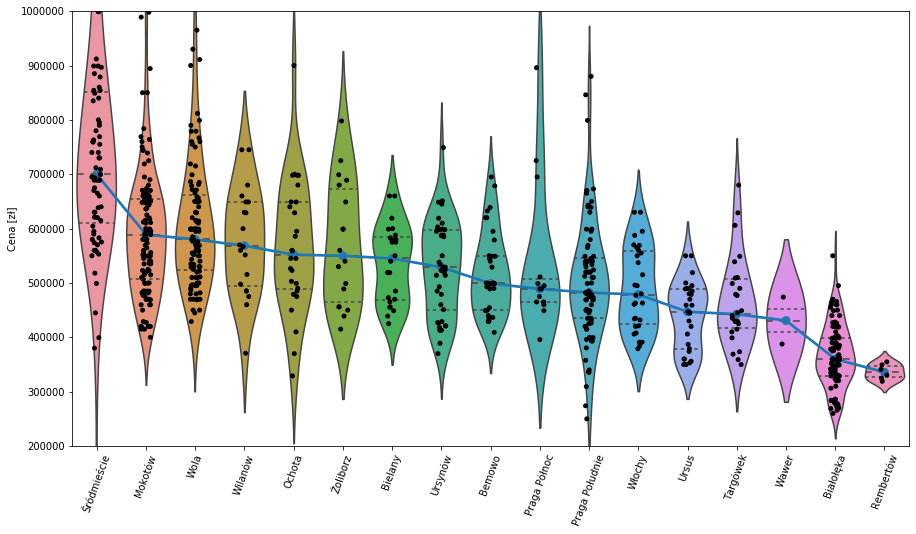

In [463]:
df = apartaments.copy()
df = df[df['Powierzchnia'] <= 60]
df = df[df['Powierzchnia'] >= 40]

order = df.groupby('Nazwa dzielnicy')['Cena'].describe()['50%'].sort_values(ascending=False)

plt.figure(figsize=(15,8))
sns.violinplot(x='Nazwa dzielnicy', y='Cena', data=df, order=order.index, scale='width', inner='quartile')
sns.stripplot(x='Nazwa dzielnicy', y='Cena', data=df, order=order.index, color='k')
sns.pointplot(x='Nazwa dzielnicy', y='Cena', data=df.groupby('Nazwa dzielnicy', as_index=False).median(), order=order.index)


plt.ylim(200_000, 1e6)
plt.xticks(rotation=70)
plt.ylabel('Cena [zł]')
plt.xlabel('')

*All violinplots are ordered by median price.*

*`Blue line` connects median prices*

*`Strips` show density of data for particular district*

## Comment:

Most popular districts, with biggest number of apartaments for sale are `Śródmieście`, `Mokotów`, `Wola`, `Praga Południe` and `Białołęka`.

`Śródmieście` is clearly the most expensive place to buy an apartament. Prices in `Mokotów` and `Wola` are about 15% smaller, prices in `Praga Południe` are 30% smaller than in `Śródmieście` and `Białołęka` is the cheapest district, with median prices about 50% smaller than in `Śródmieście`.

## 3.2. Show median price for each district
for apartaments with `Area` restricted to $40$ $m^2$ $\leq$ `Area` $\leq 60$ $m^2$

In [466]:
df = apartaments.copy()
df = df[df['Powierzchnia'] <= 60]
df = df[df['Powierzchnia'] >= 40]

plot_dict = df.groupby('Numer dzielnicy')['Cena'].describe()['50%']
plot_dict.index = [str(i) for i in plot_dict.index]  # convert to type string, so plotting works properly

In [467]:
df = apartaments.copy()
df = df[df['Powierzchnia'] <= 60]
df = df[df['Powierzchnia'] >= 40]

pd.DataFrame(df.groupby('Nazwa dzielnicy')['Cena'].describe()['50%'].astype('int32').rename('Mediana cen [zł]').sort_values(ascending=False))

,Mediana cen [zł]
Nazwa dzielnicy,
Śródmieście,700000
Mokotów,589000
Wola,580000
Wilanów,568500
Ochota,552000
Żoliborz,550000
Bielany,545000
Ursynów,529000
Bemowo,499000


In [468]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena']) + "zł"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

## 3.3. Correlate data
Restrict `maximum price` to `2 000 000 zł` to avoid sparse data.

In [469]:
df = apartaments.copy().drop(columns=['Numer dzielnicy'])
df = df[df['Cena'] <= 2e6]  # Restriction

# Convert columns 'Piętro' and 'Liczba pokoi' to numeric values
dict_ = dict({"parter" : 0, "poddasze" : np.nan, "> 10" : np.nan, "więcej niż 10" : np.nan, "suterena" : np.nan})
df = df.replace({"Piętro" : dict_})
df = df.replace({"Liczba pokoi" : dict_})
df['Piętro'] = df['Piętro'].astype('float')
df['Liczba pokoi'] = df['Liczba pokoi'].astype('float')

## 3.4. Big heatmap of correlations
source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

,Cena,Powierzchnia,Liczba pokoi,Piętro,Liczba pięter,Rok budowy,φ,λ,Czas dojazdu do centrum,Odległość od najbliższej stacji metra,Odległość od centrum
Cena,1.000000,0.784592,0.556555,0.014006,-0.031405,-0.022925,-0.289410,0.115157,-0.185626,-0.277462,-0.167937
Powierzchnia,0.784592,1.000000,0.793151,-0.078290,-0.163221,0.015515,-0.187369,0.187505,0.084575,0.036352,0.136365
Liczba pokoi,0.556555,0.793151,1.000000,-0.039836,-0.151667,0.013897,-0.095818,0.132556,0.114623,0.094297,0.147798
Piętro,0.014006,-0.078290,-0.039836,1.000000,0.480648,-0.026425,-0.032563,-0.132461,-0.173038,-0.195094,-0.191000
Liczba pięter,-0.031405,-0.163221,-0.151667,0.480648,1.000000,0.024545,-0.009959,-0.139549,-0.317432,-0.212106,-0.313992
Rok budowy,-0.022925,0.015515,0.013897,-0.026425,0.024545,1.000000,0.016707,0.018751,0.155132,0.118538,0.142209
φ,-0.289410,-0.187369,-0.095818,-0.032563,-0.009959,0.016707,1.000000,-0.145795,0.186280,0.227937,0.058553
λ,0.115157,0.187505,0.132556,-0.132461,-0.139549,0.018751,-0.145795,1.000000,0.149535,0.034576,0.272327
Czas dojazdu do centrum,-0.185626,0.084575,0.114623,-0.173038,-0.317432,0.155132,0.186280,0.149535,1.000000,0.600521,0.851607
Odległość od najbliższej stacji metra,-0.277462,0.036352,0.094297,-0.195094,-0.212106,0.118538,0.227937,0.034576,0.600521,1.000000,0.659004


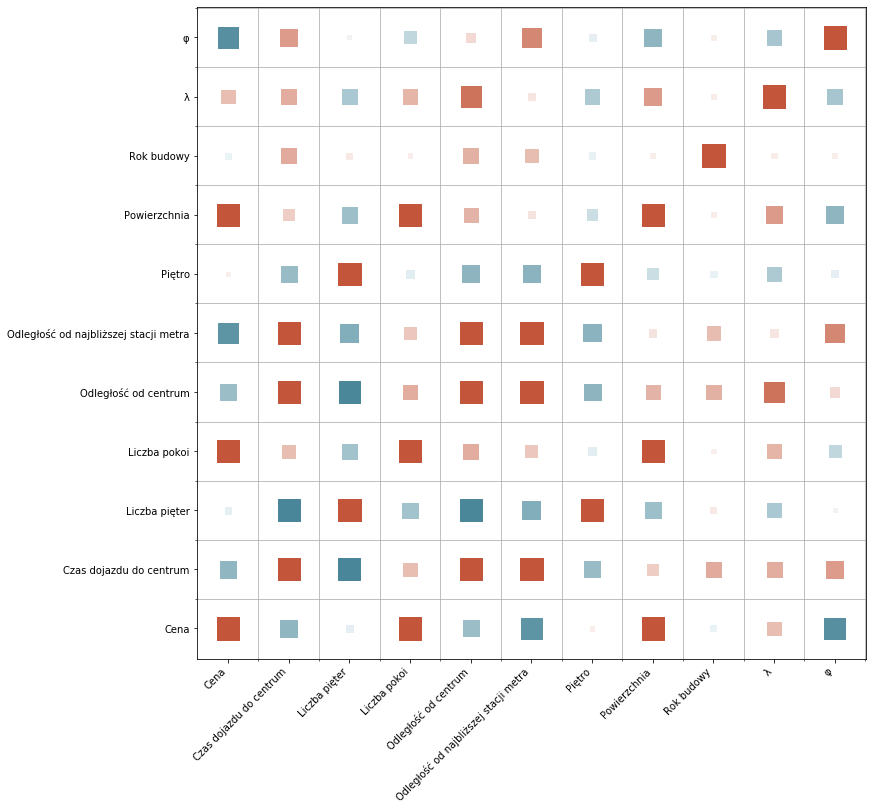

In [470]:
corr = df.corr()  #.style.background_gradient(cmap='coolwarm')
display(corr)

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)


corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    # Exaggerate colors to stress if there is ANY correlation, even little
    size=corr['value'].abs().apply(lambda x: min(1, 3*x)), 
    color=-corr['value'].apply(lambda x: max(-1, min(1, 3*x)))
)

## 3.5. Various interesting correlated plots

3.5.1. `Area`/`Number of rooms`/`Floor number` vs `Price`

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

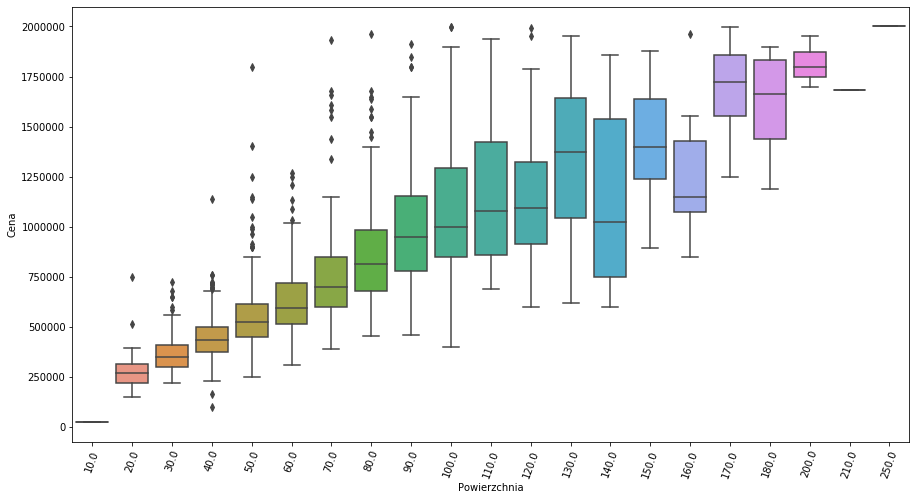

In [471]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)

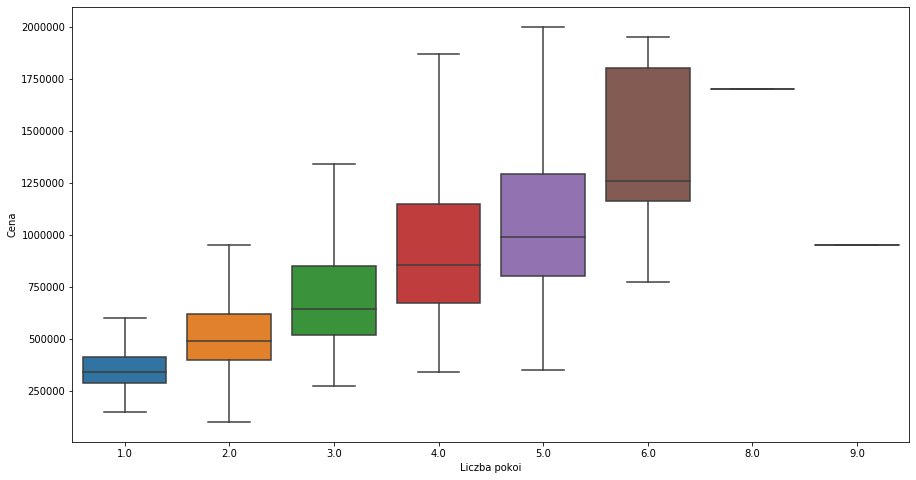

In [472]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena', data=df, showfliers=False)

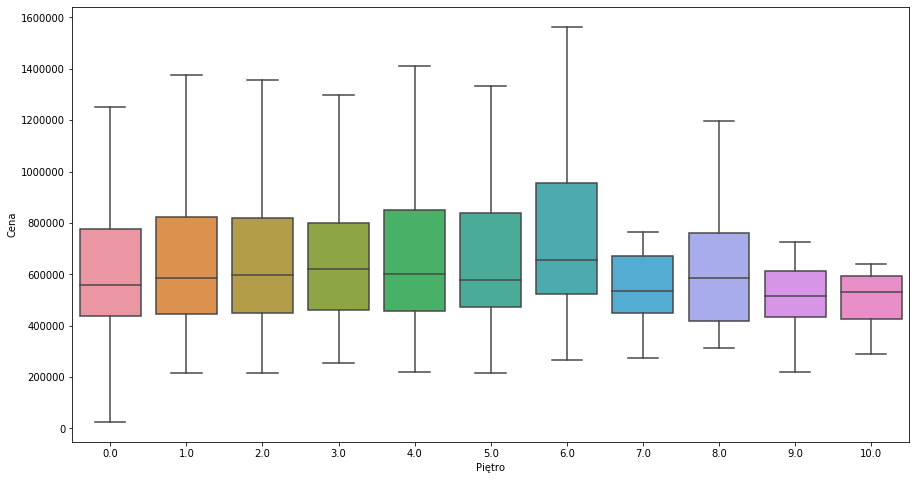

In [475]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena', data=df, showfliers=False)

3.5.2. `Distance from city center`/`Distance from metro`/`Time travel to city center` vs `Price`

(250000, 1000000)

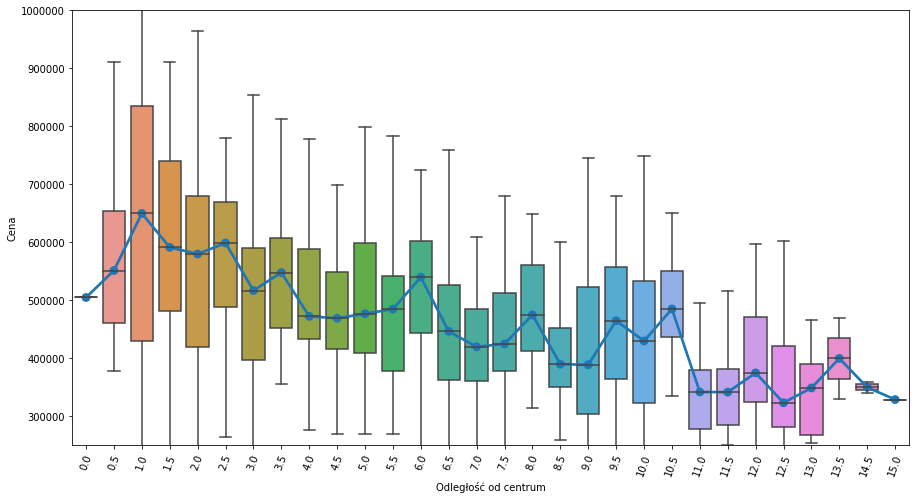

In [476]:
plt.figure(figsize=(15,8))

df_ = df[df['Powierzchnia'] <= 60].apply(lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od centrum' else x)

sns.boxplot(x='Odległość od centrum', y='Cena', data=df_, showfliers=False)#, scale='width', inner='quartile')
sns.pointplot(x='Odległość od centrum', y='Cena', data=df_.groupby('Odległość od centrum', as_index=False).median())

plt.xticks(rotation=70)
plt.ylim(250_000, 1_000_000)

(250000, 1000000)

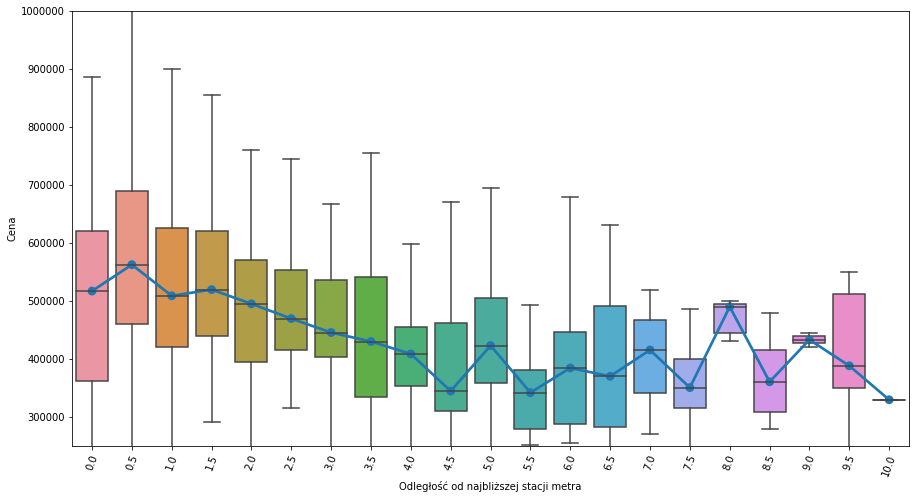

In [477]:
plt.figure(figsize=(15,8))

df_ = df[df['Powierzchnia'] <= 60].apply(lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od najbliższej stacji metra' else x)

sns.boxplot('Odległość od najbliższej stacji metra', 'Cena', data=df_, showfliers=False)#, scale='width', inner='quartile')
sns.pointplot(x='Odległość od najbliższej stacji metra', y='Cena', data=df_.groupby('Odległość od najbliższej stacji metra', as_index=False).median())

plt.xticks(rotation=70)
plt.ylim(250_000, 1_000_000)

(250000, 1000000)

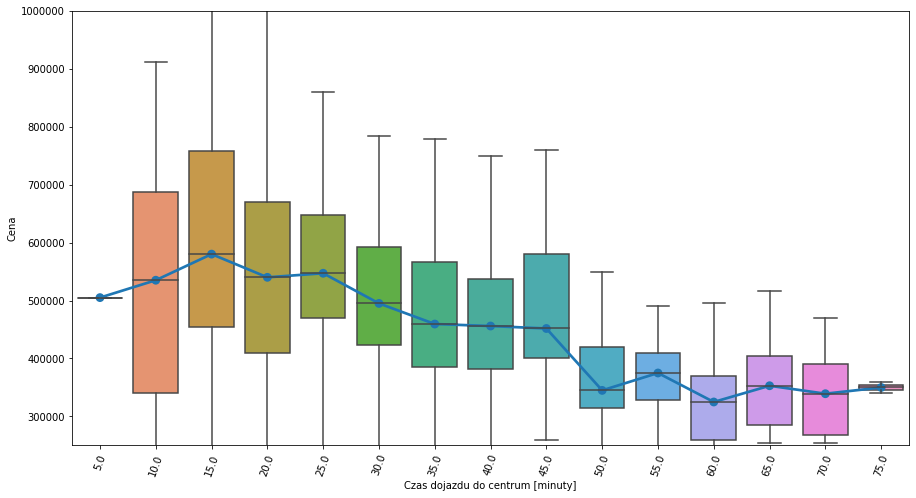

In [478]:
plt.figure(figsize=(15,8))

df_ = df[df['Powierzchnia'] <= 60].apply(lambda x: round(x/5)*5 if x.name == 'Czas dojazdu do centrum' else x)

sns.boxplot('Czas dojazdu do centrum', 'Cena', data=df_, showfliers=False)#, scale='width', inner='quartile')
sns.pointplot(x='Czas dojazdu do centrum', y='Cena', data=df_.groupby('Czas dojazdu do centrum', as_index=False).median())

plt.xticks(rotation=70)
plt.xlabel('Czas dojazdu do centrum [minuty]')
plt.ylim(250_000, 1_000_000)

3.5.3 `Number of floors` vs `distance from city center`

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

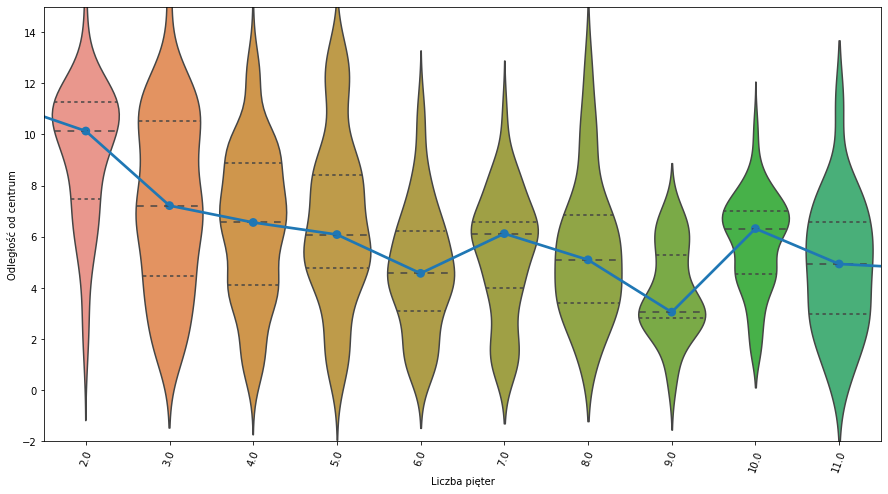

In [479]:
plt.figure(figsize=(15,8))

df_ = df.copy()

sns.violinplot('Liczba pięter', 'Odległość od centrum', data=df_, showfliers=False, scale='width', inner='quartile')
sns.pointplot('Liczba pięter', 'Odległość od centrum', data=df_.groupby('Liczba pięter', as_index=False).median())

plt.xlim(0.5, 10.5)
plt.ylim(-2, 15)
plt.xticks(rotation=70)

3.5.4. `Year of building` vs `Distance from city center`/`Price`

(-0.5, 12.5)

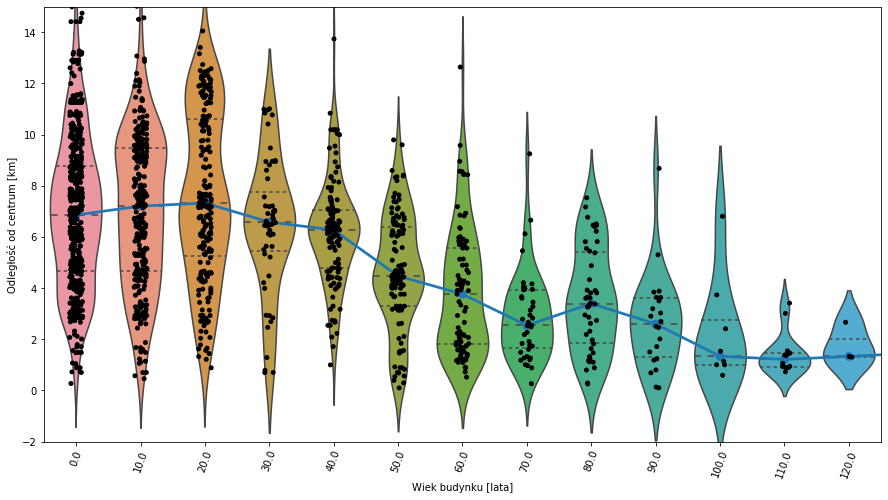

In [584]:
plt.figure(figsize=(15,8))

df_ = df.apply(lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x)

sns.violinplot('Rok budowy', 'Odległość od centrum', data=df_, showfliers=False, scale='width', inner='quartile')
sns.pointplot(x='Rok budowy', y='Odległość od centrum', data=df_.groupby('Rok budowy', as_index=False).median())
sns.stripplot(x='Rok budowy', y='Odległość od centrum', data=df_, color='k')

plt.xticks(rotation=70)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')
plt.ylim(-2, 15)
plt.xlim(-0.5, 12.5)

Text(0, 0.5, 'Cena rzeczysita [zł]')

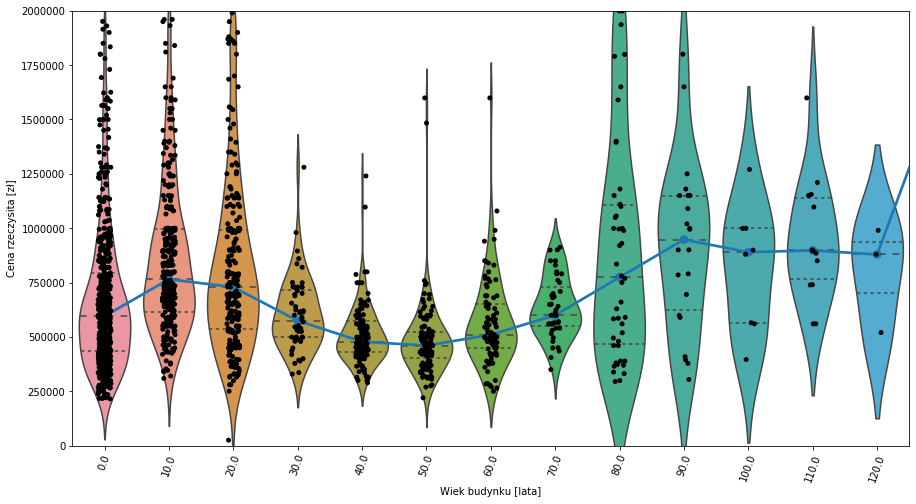

In [583]:
plt.figure(figsize=(15,8))

df_ = df.apply(lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x)

sns.violinplot('Rok budowy', 'Cena', data=df_, showfliers=False, scale='width', inner='quartile')         
sns.pointplot(x='Rok budowy', y='Cena', data=df_.groupby('Rok budowy', as_index=False).median())
sns.stripplot(x='Rok budowy', y='Cena', data=df_, color='k')
               
plt.xticks(rotation=70)
plt.xlim(-0.5, 12.5)
plt.ylim(0, 2_000_000)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Cena rzeczysita [zł]')

## Comments:

1.
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price` and `distance to city center`, aswell as between `nearest metro station location` and `price`

2.
- from analysing `number of floors` vs `distance from city center` plot we notice, that `heighest buldings` are near city center, and their height noticably decreses with their `distance from city center`

3.

- analysing `building's age` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`
- from `price` vs `building's age` plot we see that the minimum price is for `age = 50 years` (buildings build at year 1970). New buldings aswell as very old buldings are `worth the most`.

# 3.4. Distribution of apartment's floor level

Text(0, 0.5, 'Ilość mieszkań')

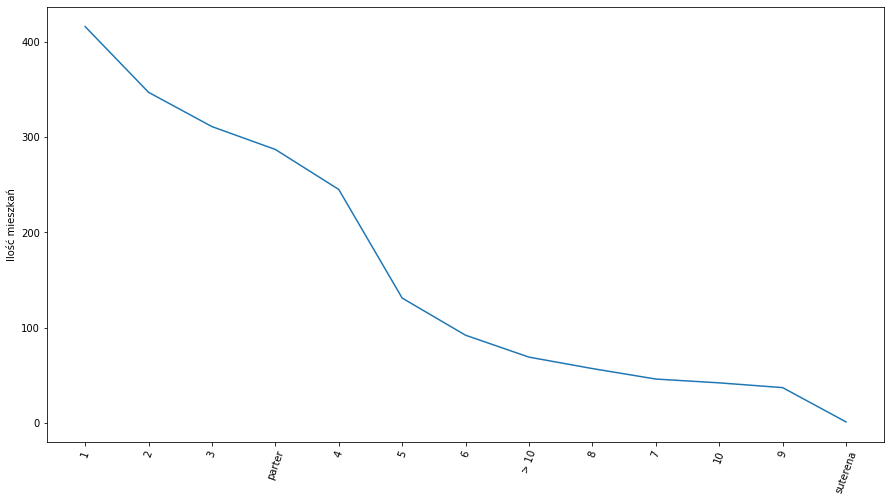

In [482]:
plt.figure(figsize=(15,8))
plt.plot(apartaments['Piętro'].value_counts())
plt.xticks(rotation=70)
plt.ylabel('Ilość mieszkań')

## Comment:
Most apartaments are suprisingly located not on the `groud floor` (parter), but rather on 1st, 2nd or 3rd floor.

# 4. Prediction
An approach to predict `real price` of a property basing on its `area`, `number of rooms`, `location`, `year of build` and `travel time`.

## 4.1. Import libraries

In [483]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [515]:
apartaments.shape

(2214, 22)

## 4.2. Prepare input (`x`) and target (`y`) variables
Restrict `maximum price` to `2 000 000 zł` to avoid sparse data.

In [570]:
df_ = apartaments.copy()
df_ = df_[df_['Cena'] <= 2e6]  # Restriction

# Convert columns 'Piętro' and 'Liczba pokoi' to numeric values
dict_ = dict({"parter" : 0, "poddasze" : np.nan, "> 10" : np.nan, "więcej niż 10" : np.nan, "suterena" : np.nan})
df_ = df_.replace({"Piętro" : dict_})
df_ = df_.replace({"Liczba pokoi" : dict_})
df_['Piętro'] = df_['Piętro'].astype('float')
df_['Liczba pokoi'] = df_['Liczba pokoi'].astype('float')


# Convert other string values to integers
def Encode(df_):
    for column in df_.columns[df_.columns.isin(['Okna'])]:
        df_[column] = df_[column].factorize()[0]
    return df_

                      
X = ['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum']
Y = ['Cena']

df_ = Encode(df_[X + Y]).dropna() # Remember to drop Nans

x = df_[X]
y = df_[Y]

## 4.3. Split to training and test set, then scale values

In [571]:
# Split into equal (or not) lenght train and test sets

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.3, random_state = 324)
print("Train set size is {} elements".format(x_train.shape[0]))
print("Test set size is {} elements".format(x_test.shape[0]))

# Scale train and test set, basing only on train data

scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

Train set size is 1147 elements
Test set size is 492 elements


## 4.4. Learn using support vector mashines (SVM) with `rbf` kernel
Adjust `C` and `gamma` values for `best performance` on `test set`

In [572]:
regressor = SVR(C=1000000, gamma=0.1) 
#regressor = LinearRegression()
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## 4.5. a) Calculate error on train set

Mean square error is 150617.98492882072
R^2 score is 0.8145235267952575


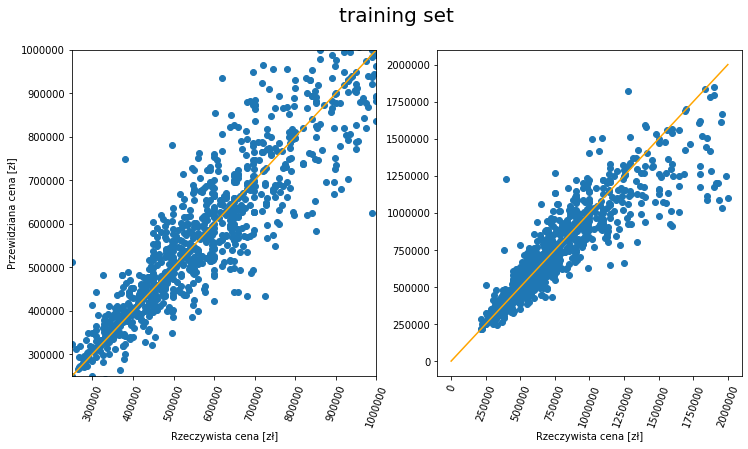

In [573]:
fig = plt.figure(figsize=(12,6))
y_pred_train = regressor.predict(x_train)

fig.add_subplot(1,2,1)
plt.scatter(y_train, y_pred_train)
plt.plot([0, 2000000], [0, 2000000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xticks(rotation=70)
plt.xlim(250_000, 1_000_000)
plt.ylim(250_000, 1_000_000)

fig.add_subplot(1,2,2)
plt.scatter(y_train, y_pred_train)
plt.plot([0, 2000000], [0, 2000000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
#plt.ylabel('Przewidziana cena [zł]')
plt.xticks(rotation=70)
fig.suptitle('training set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
r2 = r2_score(y_train, y_pred_train)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.5. b) Calculate error on test set

Mean square error is 153261.95302829047
R^2 score is 0.772185533960658


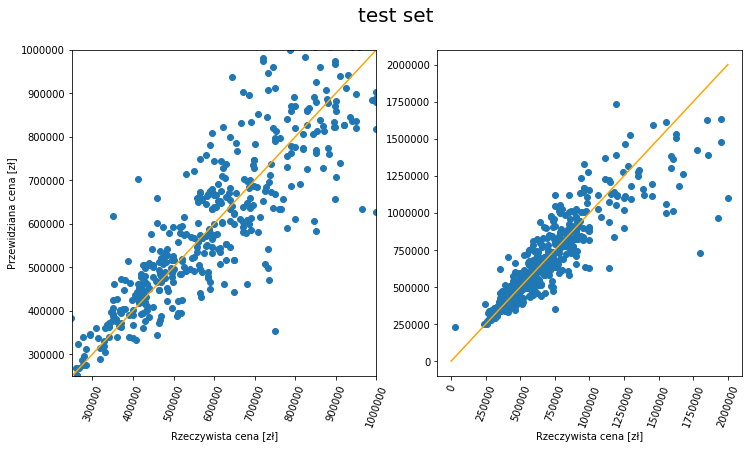

In [574]:
fig = plt.figure(figsize=(12,6))
y_pred_test = regressor.predict(x_test)

fig.add_subplot(1,2,1)
plt.scatter(y_test, y_pred_test)
plt.plot([0, 2000000], [0, 2000000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.ylabel('Przewidziana cena [zł]')
plt.xticks(rotation=70)
plt.xlim(250_000, 1_000_000)
plt.ylim(250_000, 1_000_000)

fig.add_subplot(1,2,2)
plt.scatter(y_test, y_pred_test)
plt.plot([0, 2000000], [0, 2000000], color='orange')
plt.xlabel('Rzeczywista cena [zł]')
plt.xticks(rotation=70)
fig.suptitle('test set', fontsize=20)

mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## 4.6. Analyse of error in regression approach

,train error,test error
count,1147.000000,492.000000
mean,0.169347,2.925141
std,16.907706,40.615250
min,-47.345649,-59.619995
25%,-9.076079,-9.142170
50%,-0.000004,0.651971
75%,7.760474,10.715804
max,206.728677,820.239109


Text(0.5, 0, 'relative error [%]')

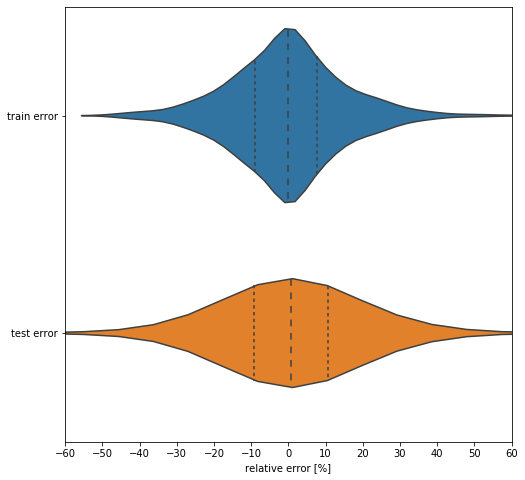

In [575]:
# For all predicted values measure relative difference from exact value and analyse that distribution

train_error = [100*(y_pred_train[i] - float(y_train.iloc[i])) / float(y_train.iloc[i]) for i in range(len(y_train))]
test_error = [100*(y_pred_test[i] - float(y_test.iloc[i])) / float(y_test.iloc[i]) for i in range(len(y_test))]

error_df = pd.DataFrame([train_error, test_error]).T.rename(columns={0:'train error', 1:'test error'})
display(error_df.describe())


plt.figure(figsize=(8,8))
sns.violinplot(data=error_df, inner='quartile', orient='h')
plt.xlim(-50,50)
plt.xticks(np.arange(-60, 65, 10))
plt.xlabel('relative error [%]')

## Comment:

`50% of data` in training set has relative error in range `(-9, 7.5)%`, what means that about `8% relative error` for half of the training set.

Similarly, `50% of data` in test set has relative error inside range `(-9, 10.5)%`, which is `10% relative error` on average.

**For example:** if we have a sample of apartament from `test set` that has price `500.000 zł in advertisement`, this algorithm has `50% chance` to predict price in range `(455.000, 552.000) zł`.

## 4.7. Test on some hand-typed data

In [585]:
test = pd.DataFrame([[68.80, 3, 52.147, 21.047, 1980, 29]], columns=['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy', 'Czas dojazdu do centrum'])
test_ = scaler_x.transform(test)
display(test)

print("For an apartment with area = {} m^2, {} room(s), build in {} and located at ({}, {}), predicted price is {} zł.".
      format(test['Powierzchnia'].iloc[0], test['Liczba pokoi'].iloc[0], test['Rok budowy'].iloc[0]
             , test['φ'].iloc[0], test['λ'].iloc[0], round(regressor.predict(test_)[0])))

,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy,Czas dojazdu do centrum
0,68.8,3,52.147,21.047,1980,29


For an apartment with area = 68.8 m^2, 3 room(s), build in 1980 and located at (52.147, 21.047), predicted price is 654283.0 zł.


## Comment:
True price for entered apartament in advertisement is `650.000 zł`, so this prediction is literally perfect.